# Fast Gaussian Process Regression

In [96]:
import qmcpy as qp 
import torch 
import numpy as np 
import scipy.stats
import collections
from matplotlib import pyplot,cm

In [97]:
pyplot.style.use("seaborn-whitegrid")
LW = 3
CISIZE = .99
MARKERSIZE = 50
ALPHA = .5
COLORS = ["xkcd:grass green","xkcd:sky blue","xkcd:lavender","xkcd:rose"]

In [98]:
torch.set_default_dtype(torch.float64)
DEVICE = "cpu"

In [99]:
def f_grad_f(f,x):
    assert x.ndim==2
    d = x.shape[1]
    xs = [x[:,j] for j in range(d)]
    for j in range(d): xs[j].requires_grad_()
    x = torch.vstack(xs).T
    y = f(x)
    grad = [None]*d 
    for j in range(d):
        grad[j] = torch.autograd.grad(y,xs[j],grad_outputs=torch.ones_like(y),create_graph=True)[0]
    y_grad_y = torch.vstack([y]+grad).T 
    return y_grad_y.detach()

## 1d example

In [178]:
d = 1
n = 2**3
f = lambda x: np.pi*x[:,0]*torch.sin(4*np.pi*x[:,0])*torch.exp(-.01/(1/2-torch.abs(x[:,0]-1/2)))
nticks = 1000
xticks = torch.linspace(0,1,nticks+2)[1:-1]
yticks = f(xticks[:,None])

In [184]:
grid = torch.linspace(0,1,n+2)[1:-1,None]
lattice = qp.Lattice(d,seed=7) 
dnb2 = qp.DigitalNetB2(d,seed=7)

In [180]:
lbetas_no_grad = [torch.zeros((1,d),dtype=int,device=DEVICE)]
gps_no_grad = [
    ["Standard GPR with a Gaussian kernel and grid points", qp.GPR(grid,lbetas=lbetas_no_grad,device=DEVICE)],
    ["Fast GPR using a shift invariant kernel and lattice points", qp.FGPRLattice(lattice,n,lbetas=lbetas_no_grad,device=DEVICE,alpha=3)],
    ["Fast GPR using a digitally shift invariant kernel and a digital net", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_no_grad,device=DEVICE,alpha=4)],
]
for name,gp in gps_no_grad:
    print(name) 
    yf = f(gp.x)[:,None]
    data = gp.fit(yf,xticks[:,None],yticks,opt_steps=100,verbose=10,opt_noises=True)
    gp.y = yf

Standard GPR with a Gaussian kernel and grid points
        iter of 100 | MLL             L2RError        | lr              | lengthscales, global_scale, noises
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                  0 | 1.56e+08        7.39e-01        | 1.00e-01        | [1.00e+00]	[1.00e+00]	[1.00e-08]
                 10 | 1.30e+01        1.88e-01        | 1.00e-01        | [3.38e-02]	[2.96e+01]	[2.96e-07]
                 20 | 7.40e+00        2.24e-01        | 1.00e-01        | [2.85e-02]	[6.75e+00]	[6.75e-08]
                 30 | 6.23e+00        2.57e-01        | 1.00e-01        | [2.13e-02]	[2.82e+00]	[4.61e-12]
                 40 | 6.21e+00        2.57e-01        | 1.00e-01        | [2.15e-02]	[2.72e+00]	[1.00e-16]
                 50 | 6.21e+00        2.57e-01        | 1.00e-01        | [2.15e-02]	[2.71e+00]	[1.00e-16]
                 60 | 6.21e+00        2.57e-01        | 1.00e-01        | [2.15e-02]	[2.

In [ ]:
lbetas_grad = [torch.zeros((1,d),dtype=int,device=DEVICE)]+[ej for ej in torch.eye(d,dtype=int,device=DEVICE)]
print(lbetas_grad)
gps_grad = [
    ["Standard GPR with a Gaussian kernel and grid points with gradient observations", qp.GPR(grid,lbetas=lbetas_grad,device=DEVICE)],
    ["Fast GPR using a shift invariant kernel and lattice points with gradient observations", qp.FGPRLattice(lattice,n,lbetas=lbetas_grad,device=DEVICE,alpha=3)],
    ["Fast GPR using a digitally shift invariant kernel and a digital net with gradient observations", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_grad,device=DEVICE,alpha=4)],
]
for name,gp in gps_grad:
    print(name) 
    yf = f_grad_f(f,gp.x)
    data = gp.fit(yf,xticks[:,None],yticks,opt_steps=100,verbose=10,opt_noises=True)
    gp.y = yf

[tensor([[0]]), tensor([1])]
Standard GPR with a Gaussian kernel and grid points with gradient observations
torch.Size([8, 2])
        iter of 100 | MLL             L2RError        | lr              | lengthscales, global_scale, noises
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                  0 | 8.86e+09        6.92e-01        | 1.00e-01        | [1.00e+00]	[1.00e+00]	[1.00e-08 1.00e-08]
                 10 | -1.40e+01       1.77e-02        | 1.00e-01        | [3.38e-02]	[2.96e+01]	[3.94e-06 3.94e-06]
                 20 | -2.56e+01       2.19e-02        | 1.00e-01        | [4.44e-02]	[2.25e+01]	[6.64e-07 4.72e-05]
                 30 | -2.56e+01       2.21e-02        | 1.00e-01        | [4.47e-02]	[2.13e+01]	[6.99e-07 4.48e-05]
                 40 | -2.57e+01       2.20e-02        | 1.00e-01        | [4.42e-02]	[1.92e+01]	[6.68e-07 4.40e-05]
                 50 | -2.57e+01       2.18e-02        | 1.00e-01        | [

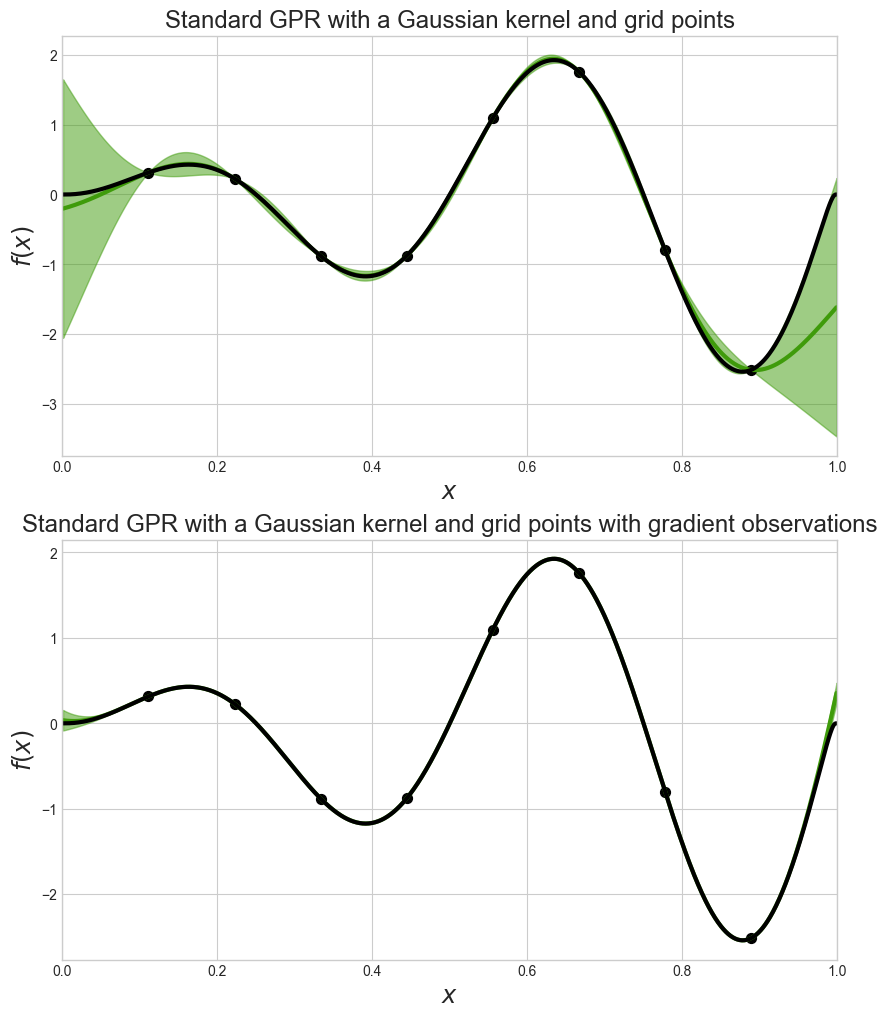

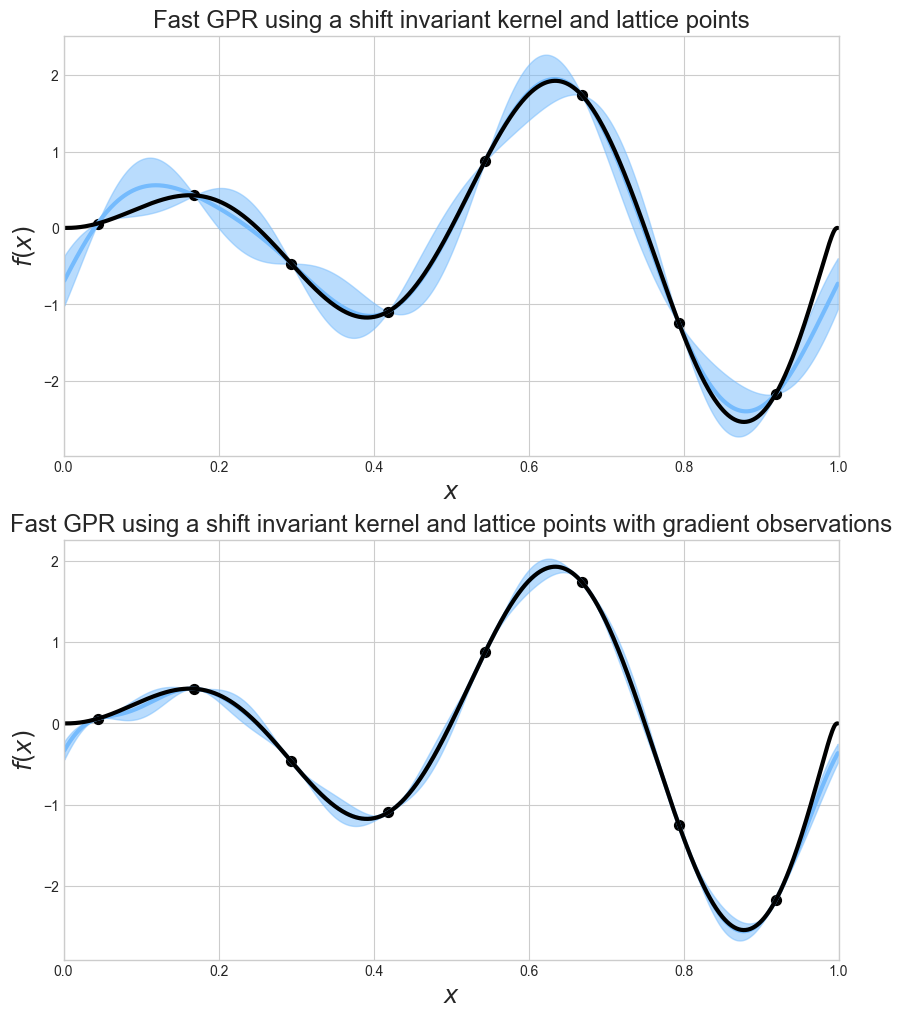

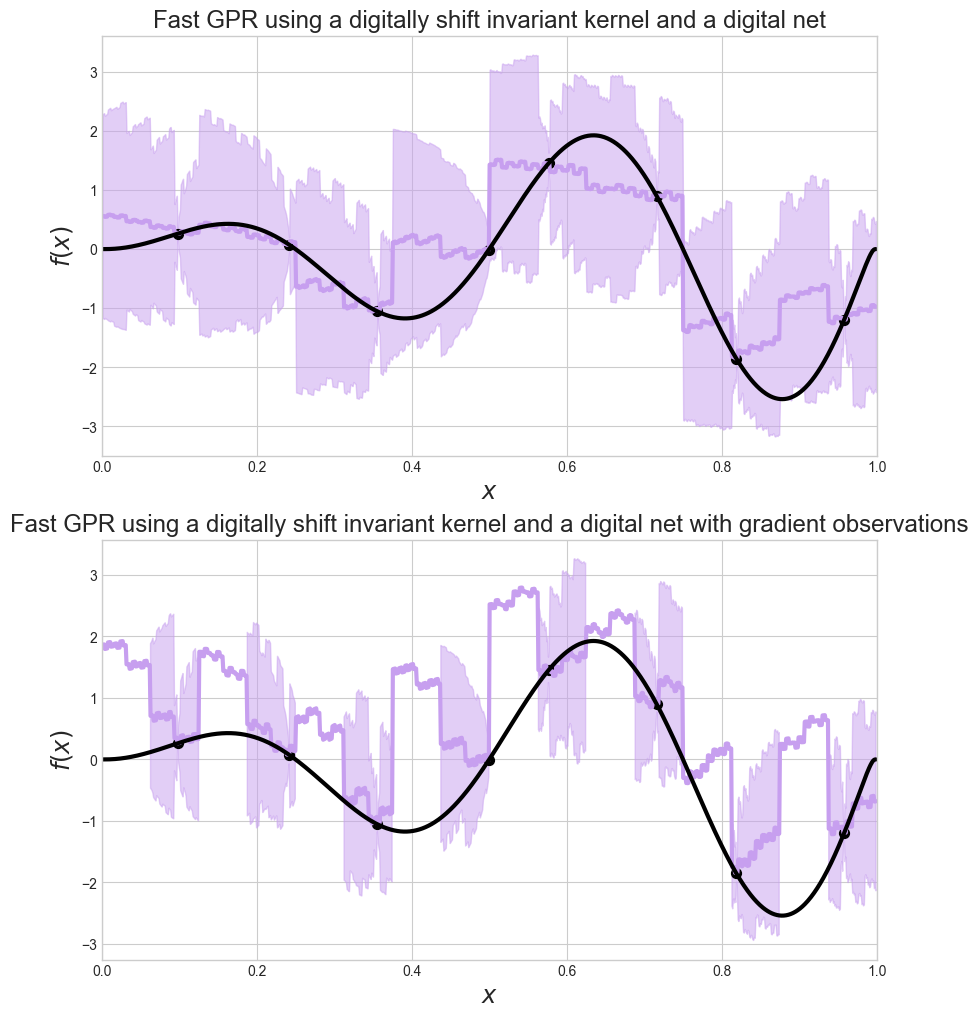

In [182]:
numgps = len(gps_no_grad) 
assert len(gps_grad)==numgps
for j in range(numgps):
    name_no_grad,gp_no_grad = gps_no_grad[j]
    name_grad,gp_grad = gps_grad[j]
    fig,ax = pyplot.subplots(nrows=2,ncols=1,figsize=(10,12),sharex=False,sharey=False)
    for i,(name,gp) in enumerate(zip([name_no_grad,name_grad],[gp_no_grad,gp_grad])):
        pmean = gp.post_mean(xticks[:,None])
        ax[i].plot(xticks,pmean,color=COLORS[j],linewidth=LW)
        pvar = gp.post_var(xticks[:,None])
        q = scipy.stats.norm.ppf(CISIZE+(1-CISIZE)/2)
        ci_low = pmean-q*torch.sqrt(pvar)
        ci_high = pmean+q*torch.sqrt(pvar)
        ax[i].fill_between(xticks,ci_high,ci_low,color=COLORS[j],alpha=ALPHA)
        ax[i].scatter(gp.x[:,0],gp.y[:,0],color="k",s=MARKERSIZE)
        ax[i].plot(xticks,yticks,color="k",linewidth=LW)
        ax[i].set_title(name,fontsize="xx-large")
        ax[i].set_xlim([0,1])
        ax[i].set_xlabel(r"$x$",fontsize="xx-large")
        ax[i].set_ylabel(r"$f(x)$",fontsize="xx-large")

## 2d example

In [240]:
d = 2
n = 2**8
# def f(x): # GFunction from https://www.sfu.ca/~ssurjano/gfunc.html
#     assert x.ndim==2
#     d = x.shape[1] 
#     a = (torch.arange(1,d+1,device=DEVICE)-2)/2
#     y = torch.prod((torch.abs(4*x-2)+a)/(1+a),dim=1)
#     return y
def f(x): # peaks function 
    x = 6*x-3
    x1,x2 = x[:,0],x[:,1]
    t1 = 3*(1-x1)**2*torch.exp(-x1**2-(x2+1)**2)
    t2 = 10*(x1/5-x1**3-x2**5)*torch.exp(-x1**2-x2**2)
    t3 = 1/3*torch.exp(-(x1-1)**2-x2**2)
    return t1-t2-t3
nticks = 33
x1ticks = x2ticks = torch.linspace(0,1,nticks+2)[1:-1]
x1mesh,x2mesh = torch.meshgrid(x1ticks,x2ticks,indexing="ij")
xticks = torch.vstack([x1mesh.flatten(),x2mesh.flatten()]).T 
yticks = f(xticks)
ymesh = yticks.reshape(x1mesh.shape)
xticks.shape

torch.Size([1089, 2])

In [241]:
grid1ticks = grid2ticks = torch.linspace(0,1,int(np.sqrt(n))+2)[1:-1]
grid1mesh,grid2mesh = torch.meshgrid(grid1ticks,grid2ticks,indexing="ij")
grid = torch.vstack([grid1mesh.flatten(),grid2mesh.flatten()]).T
assert len(grid)==n
lattice = qp.Lattice(d,seed=7) 
dnb2 = qp.DigitalNetB2(d,seed=7)

In [244]:
lbetas_grad = [torch.zeros((1,d),dtype=int,device=DEVICE)]+[ej for ej in torch.eye(d,dtype=int,device=DEVICE)]
print(lbetas_grad)
gps_grad = [
    ["Standard GPR with a Gaussian kernel and grid points with gradient observations", qp.GPR(grid,lbetas=lbetas_grad,device=DEVICE)],
    ["Fast GPR using a shift invariant kernel and lattice points with gradient observations", qp.FGPRLattice(lattice,n,lbetas=lbetas_grad,device=DEVICE,alpha=3)],
    ["Fast GPR using a digitally shift invariant kernel and a digital net with gradient observations", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_grad,device=DEVICE,alpha=4)],
]
for name,gp in gps_grad:
    print(name) 
    yf = f_grad_f(f,gp.x)
    data = gp.fit(yf,xticks,yticks,opt_steps=100,verbose=10,opt_noises=False,lb_noises=1e-5)
    gp.y = yf

[tensor([[0, 0]]), tensor([1, 0]), tensor([0, 1])]
Standard GPR with a Gaussian kernel and grid points with gradient observations
        iter of 100 | MLL             L2RError        | lr              | lengthscales, global_scale, noises
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                  0 | 1.20e+10        5.78e-01        | 1.00e-01        | [1.00e+00 1.00e+00]	[1.00e+00]	[1.00e-05 1.00e-05 1.00e-05]
                 10 | -1.74e+03       9.42e-09        | 1.00e-01        | [8.32e-03 8.32e-03]	[1.20e+02]	[1.00e-05 1.00e-05 1.00e-05]
                 20 | -5.21e+03       1.17e-04        | 1.00e-01        | [2.33e-02 1.81e-02]	[5.53e+01]	[1.00e-05 1.00e-05 1.00e-05]
                 30 | -5.23e+03       1.20e-04        | 1.00e-01        | [2.32e-02 1.82e-02]	[4.84e+01]	[1.00e-05 1.00e-05 1.00e-05]
                 40 | -5.29e+03       1.38e-04        | 1.00e-01        | [2.27e-02 1.78e-02]	[2.04e+01]	[1.00e-05 1

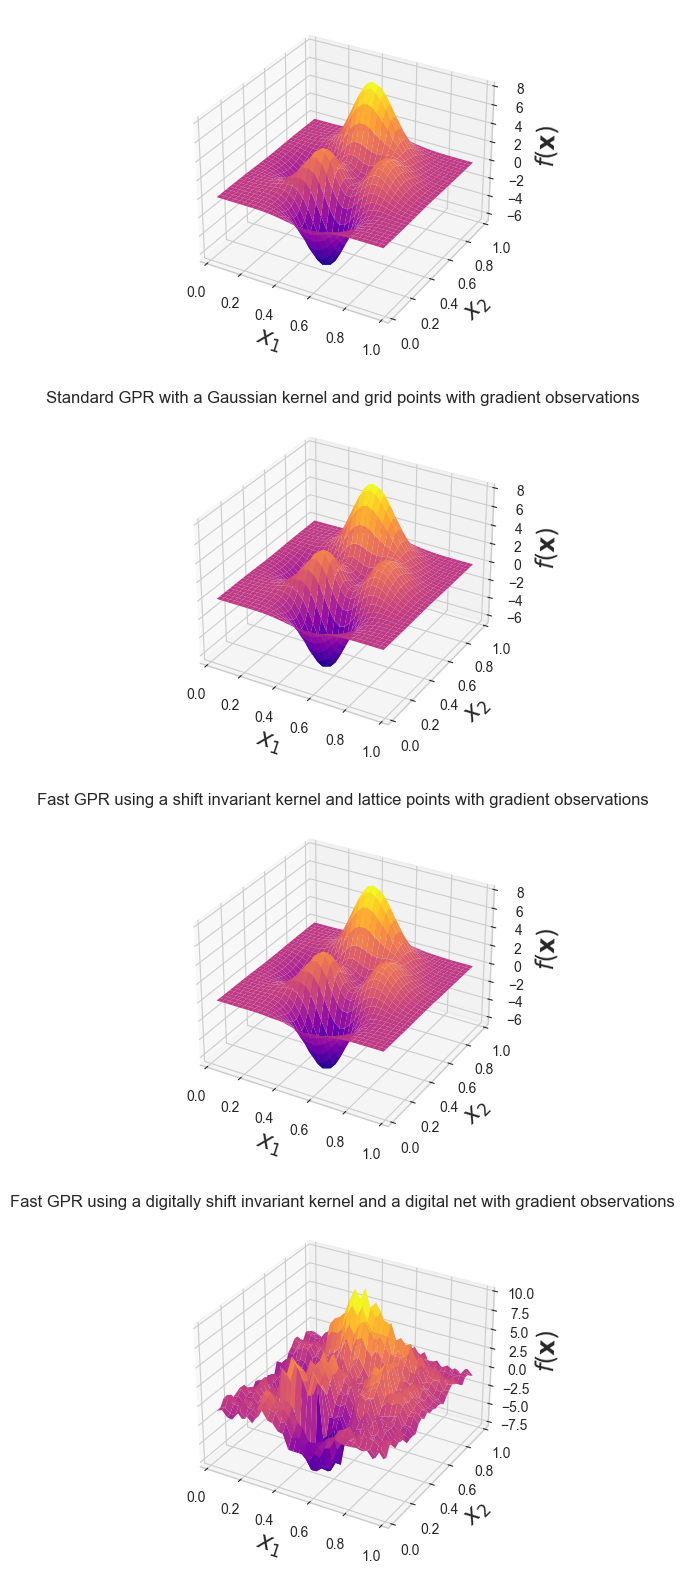

In [245]:
fig = pyplot.figure(figsize=(5,20))
ax = np.array([fig.add_subplot(4,1,i+1,projection="3d") for i in range(4)],dtype=object)
ax[0].plot_surface(x1mesh,x2mesh,ymesh,antialiased=True,cmap=cm.plasma)
for i,(name,gp) in enumerate(gps_grad):
    pmeanmesh = gp.post_mean(xticks).reshape(x1mesh.shape)
    ax[i+1].plot_surface(x1mesh,x2mesh,pmeanmesh,antialiased=True,cmap=cm.plasma)
    #ax[i+1].scatter(gp.x[:,0],gp.x[:,1],gp.y[:,0],s=MARKERSIZE,color="k")
    ax[i+1].set_title(name)
for i in range(4):
    ax[i].set_xlabel(r"$x_1$",fontsize="xx-large")
    ax[i].set_ylabel(r"$x_2$",fontsize="xx-large")
    ax[i].set_zlabel(r"$f(\mathbf{x})$",fontsize="xx-large")